# Initial Data Integrity check

In [1]:
import pandas as pd
import os

use_small_train = True

data_root = 'data/'

if use_small_train:
    train_path_of_choice = data_root + "labels/jester-v1-small-train.csv"
    video_path = data_root + "videos/small-20bn-jester-v1/"
else:
    train_path_of_choice = data_root + "labels/jester-v1-train.csv"
    video_path = 'something_else_entirely'

validation_path = data_root + "labels/jester-v1-validation.csv"

# valid is the same, regardless of the train set

train = pd.read_csv(train_path_of_choice, sep=';', header=None, names=['id', 'gesture'])
valid = pd.read_csv(validation_path, sep=';', header=None, names=['id', 'gesture'])

# get all the directory names of the subdirectories available (data is in 'big_dir/many_small_dirs/actual_images' format)
root = video_path
subdir_set = {entry.name for entry in os.scandir(root) if entry.is_dir()}

print(train.shape[0] + valid.shape[0])  # sanity check These numbers should match, withing a reasonable degree
print(len(subdir_set)) 

# concatenating the DataFrames for easy querying
train_and_valid = pd.concat([train, valid], axis=0, ignore_index=True)

available_ids = set(train_and_valid['id'].astype(str).unique())

missing_val = available_ids - subdir_set
extra_val = subdir_set - available_ids

print(f"Values (ids) available in csv, but not downloaded: {missing_val} (should be none)")
print(f"Extra values in downloaded, but not in csv: {extra_val}")

# making sure the numbers are the same (possibly redundant, but I like to check sometimes)
print("Manual checks")
val = '74335'
print(val in subdir_set)
print(val in available_ids)

train_ids = set(train['id'].astype(str).unique())
val_ids = set(valid['id'].astype(str).unique())

FileNotFoundError: [Errno 2] No such file or directory: 'data/videos/small-20bn-jester-v1/'

## Command cell (Linux ONLY): removes the extra video directory found, as it does not have a correspondent in the csv files
And I won't go searching for 1 item in the 118K row csv file

In [2]:
# !rm -r ~/CV_assignments/3_assign/downloaded_data_small/small-20bn-jester-v1/74335

In [3]:
train_and_valid = train_and_valid[~train_and_valid['id'].astype(str).isin(extra_val)]

# observing output shape, just to assess the overall size of the data available
print(f"new shape: {train_and_valid.shape}")

new shape: (38499, 2)


# Importing packages project wide

In [4]:
import os
import torch
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import pandas as pd

import torchvision.transforms as transforms

# for visualizing shadowy images
import matplotlib.pyplot as plt
import numpy as np
import random

## missing seed setting function -> 

In [5]:
# seed setting for reproducibility

# Single image with mean pixel value (baseline data)

In [6]:
root = data_root + "videos/small-20bn-jester-v1"

## Mean pixel value class

In [9]:
class JesterMeanBaselineDataset(Dataset):
    def __init__(self, data_root, annotation_file, transform=None, text_label_dict=None, trim_percent=0.3):
        self.data_root = data_root
        self.transform = transform
        self.trim_percent = trim_percent  # effectively trims the images by 2 * trim_percent. This is done to 
        # keep mostly relevant frames from the image, as usually the first trim_percent frames is the 
        # subject starring at the camera, motionless, and so are the last trim_percent frames, making
        # the output image noisy, or motionless
        
        # load CSV data
        df = pd.read_csv(annotation_file, sep=';', header=None, names=['video_id', 'label'])
        self.video_ids = df['video_id'].astype(str).tolist()
        raw_labels = df['label'].tolist()

        # id_to_label_map for future lookup of predictions (so we can see what the model predicts in language. not numbers)
        self.id_to_label_map = pd.Series(df.label.values, index=df.video_id).to_dict()

        if text_label_dict is not None:
            self.class_to_idx = text_label_dict
        else:
            # creates the gesture: numeric_label map, from the gestures in train. This will be important for Validation later
            unique_labels = sorted(list(set(raw_labels)))
            self.class_to_idx = {label: i for i, label in enumerate(unique_labels)}
            
        self.labels = [self.class_to_idx[l] for l in raw_labels]

    def __len__(self):
        return len(self.video_ids)

    def __getitem__(self, idx):
        video_id = self.video_ids[idx]
        label = self.labels[idx]
        video_dir = os.path.join(self.data_root, video_id)

        try:
            frame_names = sorted([x for x in os.listdir(video_dir) if x.endswith('.jpg')])
            # debugging: seeing how many frames there are at the beginning
            # print(f"Video {video_id}: First={frame_names[0]}, Last={frame_names[-1]}")
        except FileNotFoundError:
            print("missed some image")
            return torch.zeros(1), label

        total_frames = len(frame_names)
        
        # calculate how many frames to drop from each side
        cut_amount = int(total_frames * self.trim_percent)
        
        # it keeps everything if cut is 0.0
        if cut_amount > 0:
            # revert to keeping only the middle frame if we cut too much (trim_percent >= 0.5)
            if (total_frames - (2 * cut_amount)) <= 0:
                mid = total_frames // 2
                frame_names = [frame_names[mid]]
            else:
                # trim it up
                frame_names = frame_names[cut_amount : -cut_amount]

        self.frames_available = len(frame_names)

        # debugging: seeing how many images are left, from how many there were (previous print)
        # print(f"Video {video_id}: First={frame_names[0]}, Last={frame_names[-1]}")

        tensors = []
        for frame_name in frame_names:
            img_path = os.path.join(video_dir, frame_name)
            img = Image.open(img_path).convert('RGB')
            
            if self.transform:
                img = self.transform(img)
            tensors.append(img)

        # stack all frames. so  shape (32, 3, H, W)
        stacked_video = torch.stack(tensors)
    
        # getting the mean along "Time", sesulting in a shape of (3, H, W)
        mean_image = torch.mean(stacked_video, dim=0)
        
        return mean_image, label

In [10]:
transform = transforms.Compose([
    transforms.Resize((100, 150)),
    transforms.ToTensor()
])

baseline_data_train = JesterMeanBaselineDataset(
    data_root=root,
    annotation_file=train_path_of_choice,
    transform=transform
)

label_map = baseline_data_train.class_to_idx

baseline_data_valid = JesterMeanBaselineDataset(
    data_root=root,
    annotation_file=validation_path,
    transform=transform,
    text_label_dict=label_map
)

print(baseline_data_valid[8])

(tensor([[[0.3255, 0.3331, 0.3437,  ..., 0.4317, 0.4283, 0.4244],
         [0.3297, 0.3373, 0.3482,  ..., 0.4359, 0.4319, 0.4291],
         [0.3331, 0.3406, 0.3527,  ..., 0.4406, 0.4367, 0.4328],
         ...,
         [0.5916, 0.5854, 0.5832,  ..., 0.4317, 0.4406, 0.4364],
         [0.6031, 0.5992, 0.6048,  ..., 0.4171, 0.4373, 0.4291],
         [0.6053, 0.6073, 0.6210,  ..., 0.4070, 0.4342, 0.4289]],

        [[0.3056, 0.3132, 0.3199,  ..., 0.4471, 0.4437, 0.4398],
         [0.3098, 0.3174, 0.3244,  ..., 0.4513, 0.4473, 0.4445],
         [0.3157, 0.3232, 0.3303,  ..., 0.4577, 0.4538, 0.4499],
         ...,
         [0.5429, 0.5389, 0.5342,  ..., 0.4882, 0.4885, 0.4818],
         [0.5543, 0.5532, 0.5569,  ..., 0.4765, 0.4880, 0.4762],
         [0.5566, 0.5605, 0.5728,  ..., 0.4653, 0.4846, 0.4759]],

        [[0.2375, 0.2451, 0.2529,  ..., 0.4235, 0.4202, 0.4162],
         [0.2417, 0.2493, 0.2574,  ..., 0.4277, 0.4238, 0.4210],
         [0.2468, 0.2543, 0.2625,  ..., 0.4356, 0.4317, 0

In [11]:
def show_random_baseline_image(dataset):
    """
    Picks a random sample from the dataset, converts the tensor back to a 
    viewable image, and displays it with its label.
    """
    idx = random.randint(0, len(dataset) - 1)
    
    img_tensor, label_idx = dataset[idx]
    
    # Matplotlib expects images in format (Height, Width, Channels)
    # so we permute dimensions: (3, H, W) -> (H, W, 3)
    img_view = img_tensor.permute(1, 2, 0).numpy()
    
    # We invert the class_to_idx dictionary to get the text back
    class_to_idx = dataset.class_to_idx
    idx_to_class = {v: k for k, v in class_to_idx.items()}
    label_text = idx_to_class.get(label_idx, "Unknown")

    plt.figure(figsize=(4, 4))
    plt.imshow(img_view)
    plt.title(f"Label: {label_text} (ID: {label_idx})\n'Shadowy' Mean Image")
    plt.axis('off')
    plt.show()

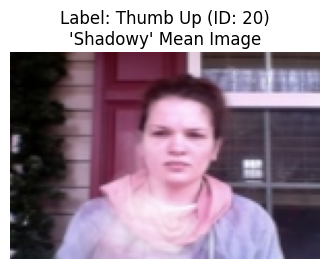

In [12]:
show_random_baseline_image(baseline_data_valid)

## Model : ResNet

In [ ]:
import torch.nn as nn
from tqdm import tqdm
import csv



class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample=False):
        super().__init__()
        stride = 2 if downsample else 1

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # If in/out channels or stride differ, adjust the shortcut path
        if downsample or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.shortcut = nn.Identity()

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += self.shortcut(x)
        out = self.relu(out)
        return out

class MyConv(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        self.stem = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        self.layer1 = ResidualBlock(64, 128, downsample=True)
        self.layer2 = ResidualBlock(128, 128)
        self.layer3 = ResidualBlock(128, 256, downsample=True)
        self.layer4 = ResidualBlock(256, 256)
        self.layer5 = ResidualBlock(256, 512, downsample=True)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.linear_stack = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

        self.apply(self._init_weights)

    @staticmethod
    def _init_weights(layer):
        if isinstance(layer, nn.Conv2d):
            nn.init.kaiming_normal_(layer.weight, mode='fan_out', nonlinearity='relu')
        elif isinstance(layer, nn.Linear):
            nn.init.kaiming_uniform_(layer.weight, nonlinearity='relu')
        elif isinstance(layer, nn.BatchNorm2d):
            nn.init.constant_(layer.weight, 1)
            nn.init.constant_(layer.bias, 0)

    def forward(self, x):
        x = self.stem(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.linear_stack(x)
        return x

In [ ]:
def evaluate(model, test_loader, criterion, device):
    """
    Evaluate the CNN classifier on the validation set.

    Args:
        model (CNN): CNN classifier to evaluate.
        test_loader (torch.utils.data.DataLoader): Data loader for the test set.
        criterion (callable): Loss function to use for evaluation.
        device (torch.device): Device to use for evaluation.

    Returns:
        float: Average loss on the test set.
        float: Accuracy on the test set.
    """
    model.eval() # Set model to evaluation mode

    with torch.no_grad():
        total_loss = 0.0
        num_correct = 0
        num_samples = 0

        for inputs, labels in test_loader:
            # Move inputs and labels to device
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Compute the logits and loss
            logits = model(inputs)
            loss = criterion(logits, labels)
            total_loss += loss.item()

            # Compute the accuracy
            _, predictions = torch.max(logits, dim=1)
            num_correct += (predictions == labels).sum().item()
            num_samples += len(inputs)


    # Evaluate the model on the validation set
    avg_loss = total_loss / len(test_loader)
    accuracy = num_correct / num_samples

    return avg_loss, accuracy


def train(model, train_loader, val_loader, optimizer, criterion, device, num_epochs,
          scheduler):
    """
    Train the CNN classifer on the training set and evaluate it on the validation set every epoch.

    Args:
    model (CNN): CNN classifier to train.
    train_loader (torch.utils.data.DataLoader): Data loader for the training set.
    val_loader (torch.utils.data.DataLoader): Data loader for the validation set.
    optimizer (torch.optim.Optimizer): Optimizer to use for training.
    criterion (callable): Loss function to use for training.
    device (torch.device): Device to use for training.
    num_epochs (int): Number of epochs to train the model.
    """

    # Place the model on device
    model = model.to(device)
    for epoch in range(num_epochs):
        model.train() # Set model to training mode

        with tqdm(total=len(train_loader),
                  desc=f'Epoch {epoch +1}/{num_epochs}',
                  position=0,
                  leave=True) as pbar:
            for inputs, labels in train_loader:
                print("...")
                #Move inputs and labels to device
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Compute the logits and loss
                logits = model(inputs)
                loss = criterion(logits, labels)

                # Do backward-chaining and update the model weights
                loss.backward()

                torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)

                optimizer.step()
                optimizer.zero_grad()

                # Update the progress bar
                pbar.update(1)
                pbar.set_postfix(loss=loss.item())

            avg_loss, accuracy = evaluate(model, val_loader, criterion, device)
            print(f'\nValidation set: Average loss = {avg_loss:.4f}, Accuracy = {accuracy:.4f}')

        scheduler.step()


def test(model, test_loader, device):
    """
    Get predictions for the test set.

    Args:
        model (CNN): classifier to evaluate.
        test_loader (torch.utils.data.DataLoader): Data loader for the test set.
        device (torch.device): Device to use for evaluation.

    Returns:
        float: Average loss on the test set.
        float: Accuracy on the test set.
    """
    model = model.to(device)
    model.eval() # Set model to evaluation mode

    with torch.no_grad():
        all_preds = []

        for inputs, labels in test_loader:
            # Move inputs and labels to device
            inputs = inputs.to(device)

            logits = model(inputs)

            _, predictions = torch.max(logits, dim=1)
            preds = list(zip(labels, predictions.tolist()))
            all_preds.extend(preds)

    print("Test predictions:")
    print(all_preds)
    return all_preds

def main(args):
    # This is stupid. I have left it like this for now, but it would make sense to get the mean and std for this dataset
    image_net_mean = torch.Tensor([0.485, 0.456, 0.406])
    image_net_std = torch.Tensor([0.229, 0.224, 0.225])

    ## Define data transformations
    train_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
        transforms.RandomResizedCrop(128),
        transforms.Resize((100, 150)),  # resize before ToTensor always
        transforms.ToTensor(),
        # transforms.Normalize(image_net_mean, image_net_std),  # no Norm, for now at least
    ])

    test_transform = transforms.Compose([
        transforms.Resize((100, 150)),
        transforms.ToTensor(),
        # transforms.Normalize(image_net_mean, image_net_std),
    ])

    # Create JesterVideos dataset object
    train_dataset = JesterMeanBaselineDataset(video_path,
                                              annotation_file=train_path_of_choice,
                                              transform=train_transform)
    val_dataset = JesterMeanBaselineDataset(video_path,
                                            annotation_file=validation_path,
                                            transform=test_transform,
                                            text_label_dict=label_map)

    # Define the batch size and number of workers
    batch_size = 64
    num_workers = 2

    # Create the dataloaders
    train_loader = DataLoader(train_dataset,
                              batch_size=batch_size,
                              num_workers=num_workers,
                              shuffle=True)

    val_loader = DataLoader(val_dataset,
                            batch_size=batch_size,
                            num_workers=num_workers,
                            shuffle=False)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print("Using device:", device)

    # Model hyperparameters
    lr = 1e-3
    # num_epochs = 40
    # num_checkpoints = 4
    num_epochs = 2
    num_checkpoints = 1

    model = MyConv(num_classes=len(train_dataset.class_to_idx))

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.001)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

    # if args.test:
    if not args["test"]:
        # if args.loaded:
        if args["loaded"]:
            # checkpoint = torch.load(args.checkpoint, weights_only=True)
            checkpoint = torch.load(args["checkpoint"], weights_only=True)
            model.load_state_dict(checkpoint['model_state_dict'])
            # first_part = int(args.checkpoint.split("_")[1].split(".")[0])
            first_part = int(args["checkpoint"].split("_")[1].split(".")[0])
        else:
            first_part = 1

        for part in range(first_part, num_checkpoints + first_part):
            print(f"\n----------------\nTraining. Part {part}/{num_checkpoints + first_part}\n")
            train(model, train_loader, val_loader, optimizer, criterion, device, num_epochs // num_checkpoints,
                  scheduler)

            torch.save({'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict()}, f'model_{part}.ckpt')

    else:
        raise NotImplementedError
        test_dataset = JesterMeanBaselineDataset(data_root,
                                                 annotation_file="Some file idk",
                                                 transform=test_transform,
                                                 text_label_dict=label_map)
        test_loader = DataLoader(test_dataset,
                                 batch_size=batch_size,
                                 num_workers=num_workers,
                                 shuffle=False)

        checkpoint = torch.load(args.checkpoint, weights_only=True)
        model.load_state_dict(checkpoint['model_state_dict'])
        preds = test(model, test_loader, device)
        write_predictions(preds, 'predictions.csv')


def write_predictions(preds, filename):
    with open(filename, 'w') as f:
        writer = csv.writer(f, delimiter=',')
        for im, pred in preds:
            writer.writerow((im, pred))

In [ ]:
# parser = argparse.ArgumentParser()
# parser.add_argument('--test', action='store_true') # This argument determines if the code will train or test
# parser.add_argument('--loaded', action='store_true') # This argument is used to load a model from a checkpoint and keep training
# parser.add_argument('--checkpoint', default='model.ckpt')  # This argument specifies the checkpoint. Used when either test or loaded are true
#
# args = parser.parse_args()
# print(args)
# main(args)

args_dict = {"test":False, "loaded":False, "checkpoint":"model.ckpt"}

main(args_dict)

Using device: cuda

----------------
Training. Part 1/2



Epoch 1/2:   0%|          | 0/371 [00:00<?, ?it/s]